In [29]:
from sympy import *
import json
import numpy as np
import matplotlib.pyplot as plt
from math import exp 
from sympy import *
from scipy.integrate import ode, odeint

In [30]:
def compute_analytic_solutions(k1_param,k_1_param,k_ds_param,k3_param,k_3_param,L_param,R_param):
    
    x,z = symbols("x z")
    lamda = symbols("lamda")
    t = symbols("t")
    c1,c2,c3 = symbols("c_1 c_2 c_3")
    k1, k_1, k3, k_3,  k_ds, L, R = symbols("k1 k_{-1} k3 k_{-3} k_{ds} L R", positive = True)


    k1 = k1.subs(k1,k1_param)
    k3 = k3.subs(k3,k3_param)
    k_1 = k_1.subs(k_1,k_1_param)
    k_3 = k_3.subs(k_3,k_3_param)
    k_ds = k_ds.subs(k_ds,k_ds_param)
    L   = L.subs(L,L_param)
    R = R.subs(R,R_param)
    
    print(k1)
    print(L)
    
    a = k1*L
    b = k_1
    c = k3
    d = k_3
    g = k_ds
    
    A = Matrix([[-a,b,0],[a, -(b+c),d],[0,c,-(d+g)]])
    
    P,D = A.diagonalize()
    eDt = Matrix([[exp(D[0,0]*t),0,0],[0,exp(D[1,1]*t),0],[0,0,exp(D[2,2]*t)]])
    eAt = P*eDt*P**(-1)
    eA0 = eAt.evalf(subs={t:0})
    ini_cond = Matrix([[R],[0],[0]])
    
    ea0 = N(eA0, chop = True)

    # first row
    phi10 = ea0[0,0]
    phi11 = ea0[0,1]
    phi12 = ea0[0,2]
    #second row
    phi20 = ea0[1,0]
    phi21 = ea0[1,1]
    phi22 = ea0[1,2]
    #third row
    phi30 = ea0[2,0]
    phi31 = ea0[2,1]
    phi32 = ea0[2,2]
    
    
    coefficients = list(nonlinsolve(([c1*phi10 + c2*phi20 + c3*phi30 - ini_cond[0], c1*phi11 + c2*phi21 + c3*phi31, c1*phi12 + c2*phi22 + c3*phi32]),[c1,c2,c3]))
    
    x_sol = eAt[0]*coefficients[0][0] + eAt[1]*coefficients[0][1]  + eAt[2]*coefficients[0][2]
    z_sol = eAt[3]*coefficients[0][0] + eAt[4]*coefficients[0][1]  + eAt[5]*coefficients[0][2]
    rho_sol = eAt[6]*coefficients[0][0] + eAt[7]*coefficients[0][1]  + eAt[8]*coefficients[0][2]
    
    x_sol = N(x_sol,chop = True)
    z_sol = N(z_sol, chop = True)
    rho_sol = N(rho_sol, chop = True)
    
    x_sol_np = lambdify(t,x_sol)
    z_sol_np = lambdify(t,z_sol)
    rho_sol_np = lambdify(t, rho_sol)
    
    return x_sol_np, z_sol_np, rho_sol_np

In [31]:
def f4_exo(t,xi,R,L,k1,k_1,k_ds,k3,k_3): 

    x = xi[0]
    z = xi[1]
    rho = xi[2]

    X1 = k_1*z - k1*L*x
    X2 = k1*L*x + k_3*rho - (k_1 + k3)*z
    X3 = k3*z - (k_3+k_ds)*rho

    return [X1, X2, X3]


In [32]:
def integrate_system(ini_cond, t0, t1, dt, R, L, k1, k_1, k_ds, k3, k_3): 
     
    ini_cond = np.array(ini_cond)

    f = f4_exo
    
    r = ode(f = f).set_integrator('dop853', nsteps = 1000000, rtol = 1e-10, verbosity = 1)
    r.set_initial_value(ini_cond, t0).set_f_params(R, L, k1, k_1,k_ds,k3,k_3)

    r = ode(f = f4_exo).set_integrator('dop853', nsteps = 100000, rtol = 1e-9, verbosity = 1)
    
    r.set_initial_value(ini_cond, t0).set_f_params(R, L, k1, k_1,k_ds,k3,k_3)

    dic_curves = {}
    
    dic_curves["time"] = []
    
    dic_curves["z"] = []
    dic_curves["x"] = []
    dic_curves["w"] = []
    dic_curves["rho"] = []
       
    a = 0
    
    while r.successful() and r.t < t1:
            
        dic_curves["time"].append(r.t + dt)
        solution = r.integrate(r.t + dt)
        
        dic_curves["x"].append(solution[0])
        dic_curves["z"].append(solution[1])
        dic_curves["rho"].append(solution[2])
        dic_curves["w"].append(R - solution[0] - solution[1] - solution[2])
        
    return dic_curves

In [33]:
def compare_solution_integration(var, times, eq_point, solution, R, L, k1, k_1, k_ds, k3,k_3, integration):
    
    if var == "z":
        concentration = "[LR]"
    elif var == "x":
        concentration = "[R]"
    elif var == "rho":
        concentration = "[LR*]"
    elif var == "w":
        concentration = "[LR_ds]"

    plt.figure(figsize = (15,7))
       
    plt.xlabel("Time(min)")
    plt.ylabel(concentration)
    
    plt.plot(times,eq_point,label=concentration +" equilibrium state.", linestyle="--", linewidth = 0.4, color = "blue")
    plt.plot(times,integration, label = concentration + "(t) from numerical integration.", color = "orange")
    plt.plot(times,solution, label = concentration + "(t) from analytical solution.", linestyle="dashdot", color = "green")
    
    plt.legend()
    
    plt.show()

### Parameters

In [34]:
L    = 310*10**(-9)
R    = 10**(-9)
k1   = 4.6*10**7
k_1  = 0.06
k_ds = 0.15
k3   = 1.54
k_3  = 1.4

t0 = 0
t1 = 45
dt = 1e-2

ini_cond = [R,0,0]

### Numerical Integration

In [35]:
print("start integration")
dic_curves = integrate_system(
        ini_cond = ini_cond,
        t0       = t0, 
        t1       = t1, 
        dt       = dt, 
        R        = R, 
        L        = L,
        k1       = k1,
        k_1      = k_1,
        k3       = k3,
        k_3      = k_3,
        k_ds     = k_ds
        )

integration_z = dic_curves["z"]
integration_rho = dic_curves["rho"]
integration_x = dic_curves["x"]
integration_w = dic_curves["w"]


start integration


### Analytic solution

In [36]:
sol_x_t, sol_z_t, sol_rho_t = compute_analytic_solutions(
    k1_param = k1,
    k_1_param = k_1,
    k_ds_param = k_ds,
    k3_param = k3,
    k_3_param = k_3,
    L_param = L,
    R_param = R)

46000000.0000000
3.10000000000000e-7


### Equilibrium points

In [37]:
t = 0

sol_x = []
sol_z = []
sol_w = []
sol_rho = []

times = []

eq_point_x = 0
eq_point_z = 0
eq_point_rho = 0
eq_point_w = R - eq_point_x - eq_point_z - eq_point_rho

eq_point_z_curve = []
eq_point_x_curve = []
eq_point_w_curve = []
eq_point_rho_curve = []

while True:

    if t >= t1:

           break

    eq_point_z_curve.append(eq_point_z)
    eq_point_x_curve.append(eq_point_x)
    eq_point_w_curve.append(eq_point_w)
    eq_point_rho_curve.append(eq_point_rho)
    
    times.append(t)

    x = sol_x_t(t).real
    z = sol_z_t(t=t).real
    rho = sol_rho_t(t=t).real
    
    w = R - x - z - rho

    sol_z.append(z)
    sol_rho.append(rho)
    sol_x.append(x)
    sol_w.append(w)
    
    t = t + dt

### Comparison 

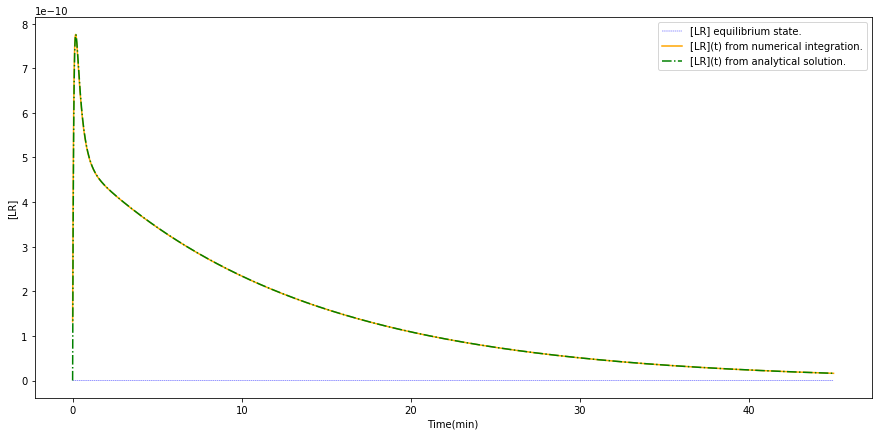

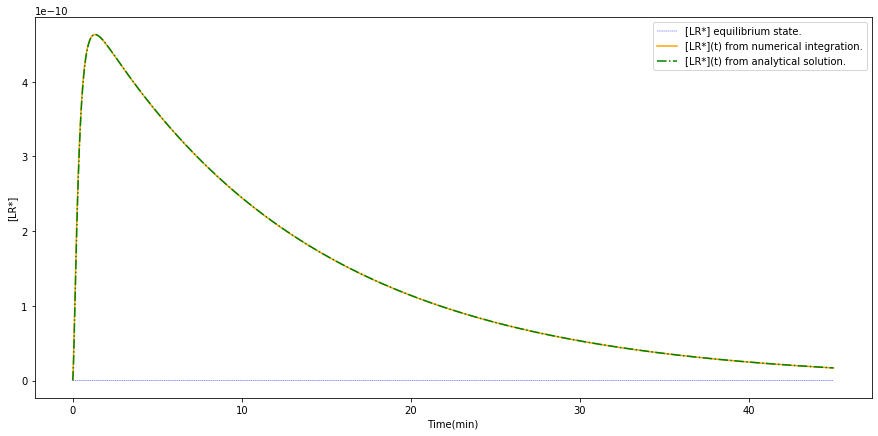

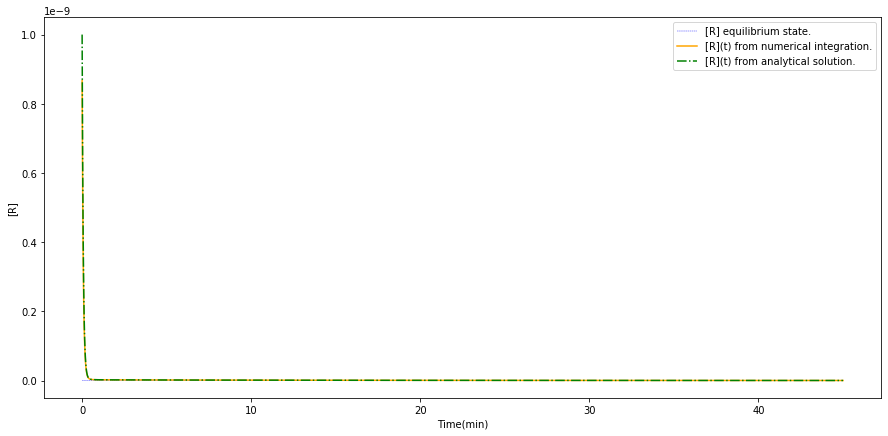

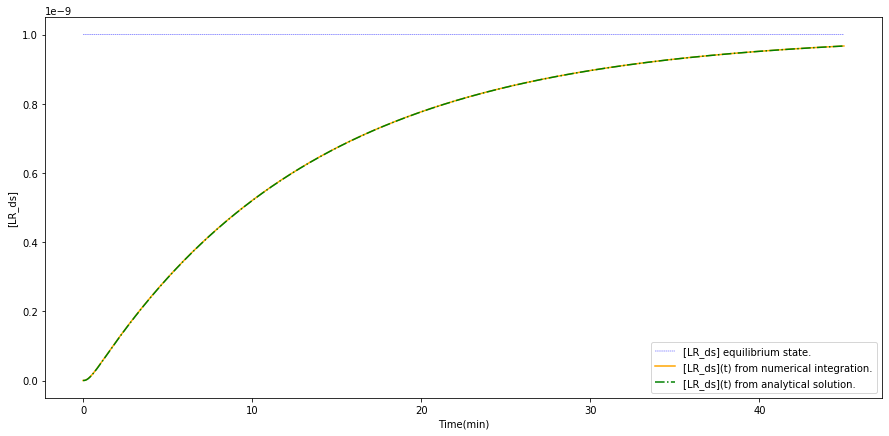

In [38]:
compare_solution_integration(
                        var = "z",
                        k1 = k1, 
                        k_1 = k_1,
                        L   = L,
                        k_ds = k_ds,
                        k3 = k3, 
                        k_3 = k_3, 
                        R   = R,
                        times = times, 
                        eq_point = eq_point_z_curve, 
                        solution = sol_z, 
                        integration=integration_z
                    )

compare_solution_integration(
                        var = "x",
                        k1 = k1, 
                        k_1 = k_1,
                        L   = L,
                        k_ds = k_ds,
                        k3 = k3, 
                        k_3 = k_3, 
                        R   = R,
                        times = times, 
                        eq_point = eq_point_x_curve, 
                        solution = sol_x, 
                        integration=integration_x
                    )
compare_solution_integration(
                        var = "w",
                        k1 = k1, 
                        k_1 = k_1,
                        L   = L,
                        k_ds = k_ds,
                        k3 = k3, 
                        k_3 = k_3, 
                        R   = R,
                        times = times, 
                        eq_point = eq_point_w_curve, 
                        solution = sol_w, 
                        integration=integration_w
                    )

In [ ]:

compare_solution_integration(
                        var = "rho",
                        k1 = k1, 
                        k_1 = k_1,
                        L   = L,
                        k_ds = k_ds,
                        k3 = k3, 
                        k_3 = k_3, 
                        R   = R,
                        times = times, 
                        eq_point = eq_point_rho_curve, 
                        solution = sol_rho, 
                        integration=integration_rho
                    )